Added trial 0 data to salp_navigate_8a/gcn
Added trial 1 data to salp_navigate_8a/gcn
Added trial 2 data to salp_navigate_8a/gcn
Added trial 3 data to salp_navigate_8a/gcn
Added trial 4 data to salp_navigate_8a/gcn
Added trial 0 data to salp_navigate_8a/gat
Added trial 1 data to salp_navigate_8a/gat
Added trial 2 data to salp_navigate_8a/gat
Added trial 3 data to salp_navigate_8a/gat
Added trial 4 data to salp_navigate_8a/gat
Added trial 0 data to salp_navigate_8a/graph_transformer
Added trial 1 data to salp_navigate_8a/graph_transformer
Added trial 2 data to salp_navigate_8a/graph_transformer
Added trial 3 data to salp_navigate_8a/graph_transformer
Added trial 4 data to salp_navigate_8a/graph_transformer
Added trial 0 data to salp_navigate_8a/gcn_full
Added trial 0 data to salp_navigate_8a/gat_full
Added trial 0 data to salp_navigate_8a/graph_transformer_full
Added trial 1 data to salp_navigate_8a/graph_transformer_full
Added trial 2 data to salp_navigate_8a/graph_transformer_full
Add

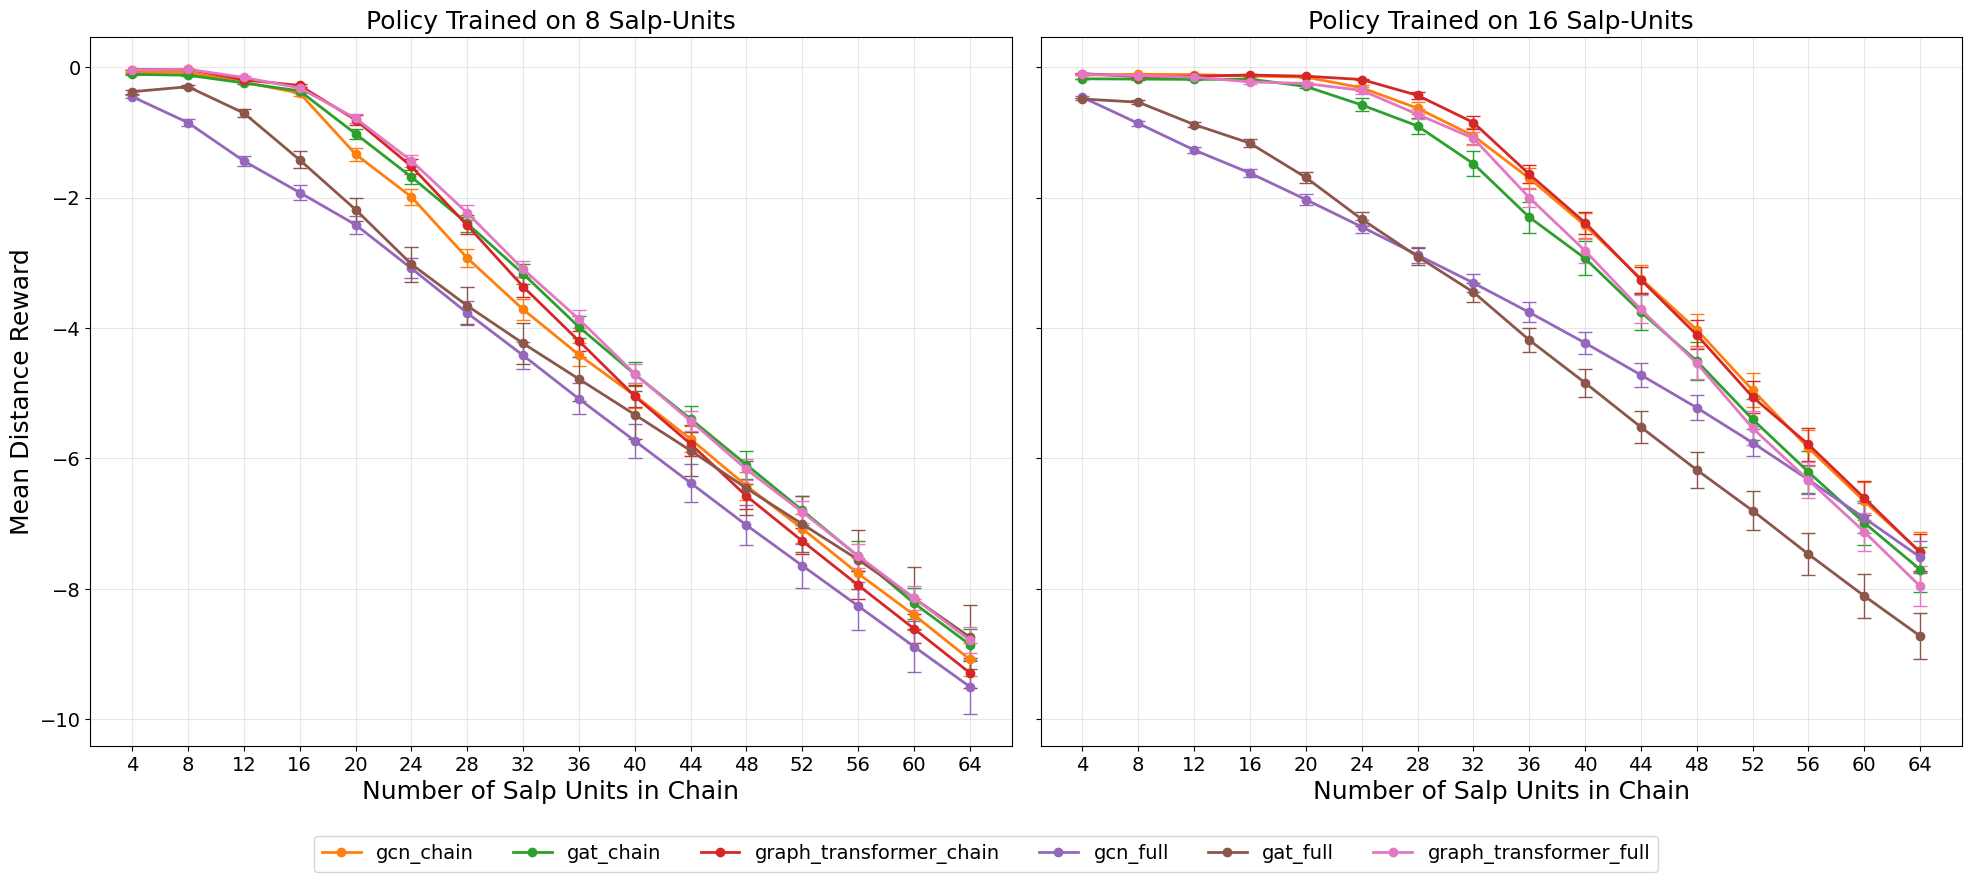

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import yaml
import pickle
from collections import defaultdict

# Set font properties for entire plot
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

plotting_dir = Path().resolve()
config_dir = plotting_dir / "ppo_config.yaml"

with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)  # sharey=True makes y-axis scale the same

# Group data by batch first, then by experiment
batch_data = {batch: defaultdict(lambda: defaultdict(list)) for batch in config["batches"]}
reward_name = "dist_rewards"

# First, collect all data points across trials
for batch in config["batches"]:
    for experiment in config["experiments"]:
        for trial in config["trials"]:
            checkpoint_path = Path(f"{config['base_path']}/{batch}/{experiment}/{trial}/logs/evaluation.dat")

            if checkpoint_path.is_file():
                with open(checkpoint_path, "rb") as handle:
                    data = pickle.load(handle)
                    
                    # Group rewards by n_agents for this experiment
                    for n in data.keys():
                        batch_data[batch][experiment][n].extend(data[n][reward_name])
                        
                print(f"Added trial {trial} data to {batch}/{experiment}")

# Use a different color for each experiment
experiment_colors = {}
color_idx = 0

# Store line objects and labels for shared legend
all_lines = []
all_labels = []

# Subplot titles - customize as needed
titles = ["Evaluation of Policy Trained on 8 Salp-Units", "Evaluation of Policy Trained on 16 Salp-Units"]
all_labels = ["gcn_mixed", "gat_mixed", "graph_transformer_mixed", "gcn_full", "gat_full", "graph_transformer_full"]

# Now plot each batch in its own subplot
for batch_idx, batch in enumerate(config["batches"]):
    ax = axes[batch_idx]
    
    # Set subplot title
    ax.set_title(titles[batch_idx])
    
    # Process experiments for this batch
    for experiment in config["experiments"]:
        # Skip if no data for this experiment
        if not batch_data[batch][experiment]:
            print(f"No data for {batch}/{experiment}")
            continue
            
        # Get consistent color for this experiment
        if experiment not in experiment_colors:
            experiment_colors[experiment] = plt.cm.tab10(color_idx+1 % 10)
            color_idx += 1
        color = experiment_colors[experiment]
        
        # Get sorted list of agent counts
        n_agents = sorted(batch_data[batch][experiment].keys())
        
        # Calculate mean and standard error across all trials
        means = [np.mean(batch_data[batch][experiment][n]) for n in n_agents]
        errors = [np.std(batch_data[batch][experiment][n]) / 
                 np.sqrt(len(batch_data[batch][experiment][n])) for n in n_agents]
        
        # Print how many samples we have for each agent count
        print(f"{batch}/{experiment}: {[len(batch_data[batch][experiment][n]) for n in n_agents]} samples per agent count")
        
        # Plot with error bars
        line = ax.errorbar(
            n_agents,
            means,
            yerr=errors,
            fmt="o-",
            linewidth=2,
            elinewidth=1,
            markersize=6,
            capsize=5,
            color=color,
            ecolor=color,
        )
        
        # Store line and label for shared legend, but only from first subplot
        if batch_idx == 0:
            all_lines.append(line[0])  # The line object is the first element of the errorbar tuple
    
    ax.set_xticks(n_agents)
    ax.set_xlabel("Number of Salp Units in Chain")
    
    # Only add y-label to first subplot
    if batch_idx == 0:
        ax.set_ylabel(f"Mean Distance Reward")
        
    ax.grid(True, alpha=0.3)

# Create a single legend for the entire figure
fig.legend(all_lines, all_labels, 
           loc='lower center',  # Position below the subplots
           bbox_to_anchor=(0.5, -0.12),  # Center horizontally, below plots
           ncol=len(all_labels),  # Put all items in one row
           fontsize=14)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)  # Add space at bottom for legend

plt.savefig("zero_shot_comparison.png", dpi=300, bbox_inches="tight")
plt.show()